# Predict Using Model

In [2]:
from main import *

## Load Model

In [13]:
model = keras.models.load_model(f'output/convolve_lstm_multilabel_model.tfsmf')

In [14]:
with open("data/data_means", "rb") as f:
    means = pickle.load(f)

with open("data/data_vars", "rb") as f:
    variances = pickle.load(f)

ranges = [
    (0, 61),
    (61, 122),
    (122, 179),
    (179, 236),
    (236, 293),
    (293, 350),
    (350, 403),
    (403, 456),
    (456, 505),
    (505, 554),
    (554, 603),
    (603, 652),
    (652, 716)
]

def generate_prediction_from_raw_data_and_frame_id(
        model, csv_i, frame_id, start=0, length=64, seed=0,
        signal_name_labels=labels,
        plot=True, plot_prediction_requirement=0.8,
        plot_length_requirement=True):
    """
    Generate a graph and return raw y predictions from input parameters.
    This function relies on random values. Seed for a different behavior.
    """
    if type(csv_i) == str:
        csv_i = pd.read_csv(csv_i)
    else:
        assert isinstance(csv_i, pd.DataFrame)

    assert start+length <= 65
    random.seed(seed)
    raw_xs, raw_ys = get_raw_signal_values(csv_i,
                                           frame_id, #frame id
                                           0,
                                           64,
                                           'little',
                                           pad_to_at_least=64
                                          )

    raw_y = raw_ys[0]  # should error if no message found on any bus
    masked_raw_ys = []
#     print(raw_y.shape, len(raw_y[0]))

    if length != 64:
#         start_positions = random.sample(range(0, 64), 10)
#         for start_position in start_positions:
#             actual_signal = [signal[start:start+length] for signal in raw_y]
#             remainder_signal = [signal[0:start] + signal[start+length:] for signal in raw_y]
#             randomized_signal = [remainder_signal[i][0:start_position] +
#                                  actual_signal[i] +
#                                  remainder_signal[i][start_position:] for i in range(len(raw_y))]
#             zeroed_randomized_signal = ['0' * start_position +
#                                  actual_signal[i] +
#                                  '0' * (64 - start_position - length) for i in range(len(raw_y))]
#             masked_raw_ys.append(np.array(randomized_signal))
#             masked_raw_ys.append(np.array(zeroed_randomized_signal))
        actual_signal = [signal[start:start+length] for signal in raw_y]
        remainder_signal = [signal[0:start] + signal[start+length:] for signal in raw_y]

        randomized_signal = [''.join(random.choice(['0', '1']) for _ in range(start)) +
                             actual_signal[i] +
                             ''.join(random.choice(['0', '1']) for _ in range(len(remainder_signal[i])-start))
                             for i in range(len(raw_y))]
        zeroed_signal = ['0' * start +
                             actual_signal[i] +
                             '0' * (64 - start - length) for i in range(len(raw_y))]
        masked_raw_ys.append(np.array(randomized_signal))
        masked_raw_ys.append(np.array(zeroed_signal))
    else:
        masked_raw_ys.append(np.array(raw_y))

    correctly_sized_signals = []

    for randomized_raw_y in masked_raw_ys:
        print(randomized_raw_y.shape, randomized_raw_y[0], type(randomized_raw_y[0]))
        correctly_sized_signals.append(
            np.array([convert_ith_original_signal_to_convolved_signal(randomized_raw_y, i) for i in range(0, len(randomized_raw_y), 100)])
        )

    standardized_signals = correctly_sized_signals

    # center and mean data
    for i in range(len(ranges)):
        for standardized_signal in standardized_signals:
            for j in range(len(standardized_signal)):
                standardized_signal[j][ranges[i][0]:ranges[i][1]] -= means[i]
                standardized_signal[j][ranges[i][0]:ranges[i][1]] /= variances[i]

    predictions = []

    for standardized_signal in standardized_signals:
        # if the signal is too short, append all 0s to it.
        if standardized_signal.shape[0] < 10000 and not plot_length_requirement:
            amount_to_pad = 10000 - standardized_signal.shape[0]
            standardized_signal = np.pad(standardized_signal, ((0, amount_to_pad), (0, 0)), mode='constant')
            print("extended signal to length 10000, as was previously not long enough")
        for i in range(0, standardized_signal.shape[0] - 100, 100):
            p = model.predict(standardized_signal[i:i+100,:][None])
            predictions.append(p.flatten())

    if not predictions:
        print("Failed to generate predictions, not enough data points.")
        return None

    averaged_prediction = np.mean(np.array(predictions), axis=0)

    if plot and any(averaged_prediction > plot_prediction_requirement):
        plt.figure(figsize=(14, 5))
        plt.title("Class Probabilities")
        plt.bar(signal_name_labels, averaged_prediction)
        plt.xticks(rotation = 15)
        plt.show()
        plt.close()
    return averaged_prediction

## Make Predictions

In [15]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [16]:
def get_frame_ids_from_csv(csv_data):
    if type(csv_data) == str:
        csv_data = pd.read_csv(csv_data)
    else:
        assert isinstance(csv_data, pd.DataFrame)
    return csv_data['MessageID'].unique()

In [17]:
nissan_csv_data = pd.read_csv("data/2021-11-11-00-20-27_JN1BJ1CW3LW375199_CAN_Messages.csv")

In [18]:
frame_ids_nissan = get_frame_ids_from_csv(nissan_csv_data)
frame_ids_nissan

array([ 412,  723, 1273,  403,  758,  346,    2,  347,  389,  348,  349,
        386,  520,  658,  665,  682,  683,  361,  438,  397,  451,  398,
        548,  574,  645,  523, 1041,  666,  855,  634,  566, 1042,  724,
        689,  772,  773,  648,  774,  654,  775,  643,  776,  674,  777,
       1105,  778, 1401, 1342,  851,  781,  517,  541,  542,  543,  544,
        546,  547,  576,  577,  582,  583,  584,  610,  782,  611,  612,
        614,  615,  616,  617,  622,  623,  675,  676,  684,  685,  783,
        686,  687, 1227, 1247,  708,  709, 1259,  711,  522,  712,  713,
        717,  718,  719,  720,  726,  727,  728,  750,  779,  539,  545,
        570,  600,  601,  638,  690,  703,  714,  715,  716,  735,  746,
        748,  749, 1258,   42, 1055, 1376, 1107, 1497, 1108, 1110, 1111,
       1266, 1104, 1474, 1229, 1514, 1534, 1001, 1228], dtype=int64)

Analyzing frame_id 412
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'str'>


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


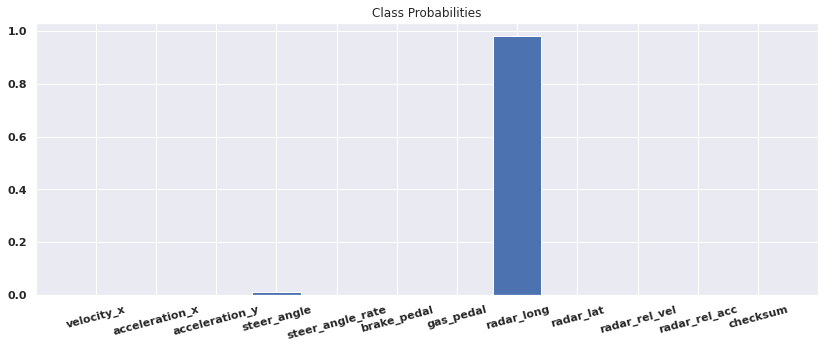

[4.9896178e-05 5.8502172e-07 7.8376819e-05 1.1220634e-02 1.2730899e-05
 1.0605186e-05 1.5345721e-07 9.8187995e-01 3.2079271e-05 5.1461666e-06
 4.2831893e-05 8.2562977e-13]
Analyzing frame_id 723
(15398,) 0001000011111001000001111110101001011100000101001101101001111000 <class 'str'>


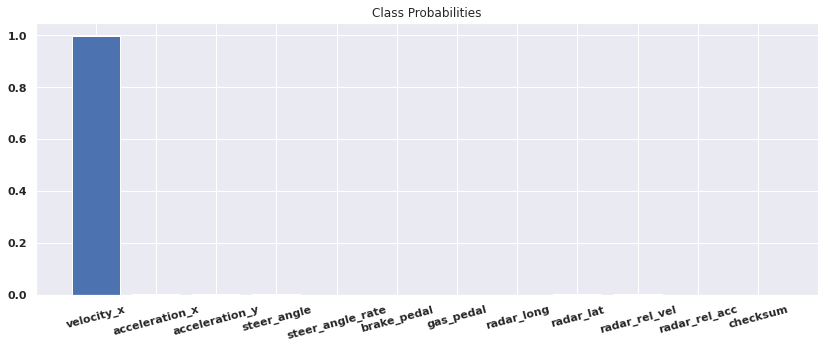

[9.9820459e-01 2.3538172e-03 2.1007657e-03 1.9281805e-03 6.3139200e-04
 2.0997750e-05 7.9435110e-04 6.9588423e-04 2.8087497e-03 1.9761026e-03
 1.8089699e-05 1.9963255e-09]
Analyzing frame_id 1273
(7699,) 0000000001100010111010010000000000000010000100010110011000000000 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 403
(30796,) 0111101100011011111010000001111101000000111110100000110001111000 <class 'str'>
[1.3791864e-01 1.5089757e-04 5.8645714e-02 5.5852573e-02 6.4444542e-04
 1.4336486e-02 6.5622288e-03 3.5222566e-01 5.6057177e-03 1.0360746e-03
 1.4656974e-01 7.3085147e-07]
Analyzing frame_id 758
(15350,) 0000000000000000000000000000000000000000000000000000000011111111 <class 'str'>
[8.5675716e-04 3.2375643e-05 7.8948736e-03 9.8520935e-02 4.3143344e-05
 2.6435852e-03 2.4971366e-04 1.3439888e-01 3.3452213e-03 5.6463097e-05
 6.0428280e-01 2.8485548e-08]
Analyzing frame_id 346
(30090,) 0000000000000000000000000000000000011011100100111001000100

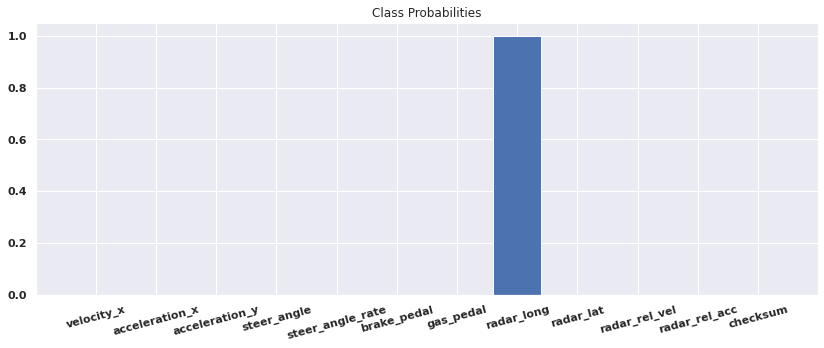

[6.5899676e-06 4.5726511e-06 1.3937854e-05 3.4384770e-04 3.2716292e-05
 6.2493805e-06 4.5038618e-07 9.9938804e-01 8.0632301e-05 8.3570885e-06
 5.9474649e-05 7.9925606e-12]
Analyzing frame_id 347
(30089,) 0000000000000000000000000011111010100011101010000000000100000000 <class 'str'>
[3.1082490e-02 6.5927212e-05 2.0593803e-03 2.9335165e-01 1.2512803e-04
 1.0413903e-04 6.5808804e-06 5.9788251e-01 3.3749142e-04 1.0233081e-04
 2.7328127e-04 2.1551367e-09]
Analyzing frame_id 389
(30796,) 0111101101010000011111111010111000000000000000000101110001110111 <class 'str'>
[1.2581651e-01 6.0550779e-01 1.3779692e-04 1.2493432e-03 2.5544325e-02
 1.7671706e-04 8.4767741e-04 3.6490956e-04 2.1293043e-04 1.7661750e-03
 1.5385599e-04 6.9398141e-08]
Analyzing frame_id 348
(30089,) 0010011111001011001110101000001111101010000101000011011000000000 <class 'str'>
[1.9102311e-01 3.3987761e-03 3.5292108e-03 9.6308190e-04 1.8542886e-02
 1.7335512e-04 9.7255201e-05 1.9813085e-04 1.9915719e-01 4.2280659e-01
 2.599198

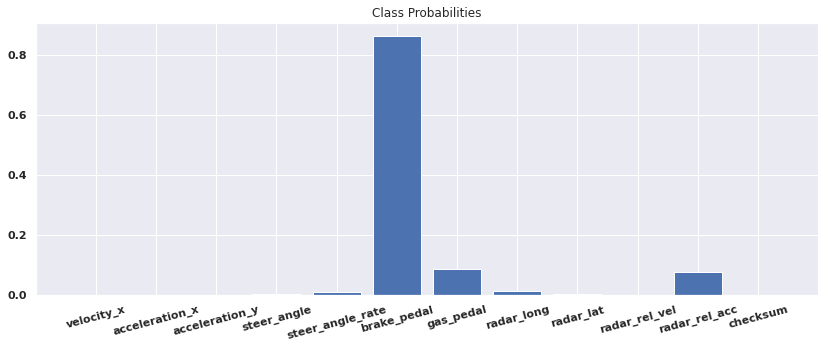

[3.0839443e-04 1.7479062e-04 2.9230118e-04 1.7054081e-03 8.3454549e-03
 8.6323261e-01 8.5311085e-02 1.0800242e-02 3.2075346e-03 6.3261390e-04
 7.7324241e-02 3.4986888e-07]
Analyzing frame_id 665
(15398,) 1111111111100000000000000001100001110000000000001111111111100000 <class 'str'>
[2.8070021e-01 4.7917157e-02 1.7511845e-04 2.8485060e-04 4.0243769e-01
 2.4211407e-04 5.3068995e-04 2.3207068e-04 8.3106756e-04 7.5157881e-03
 1.2603402e-04 7.3260310e-08]
Analyzing frame_id 682
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'str'>


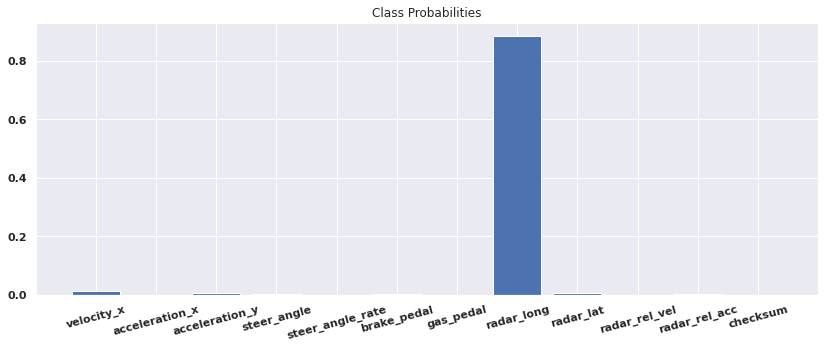

[1.2670815e-02 6.7538691e-05 4.5130849e-03 4.1556060e-03 6.2964333e-05
 1.2391508e-03 9.4746101e-05 8.8513911e-01 5.3122938e-03 1.3315678e-04
 2.6977658e-03 1.4545360e-08]
Analyzing frame_id 683
(15398,) 1111111111010111110111000000000011100000001000011000000001100100 <class 'str'>


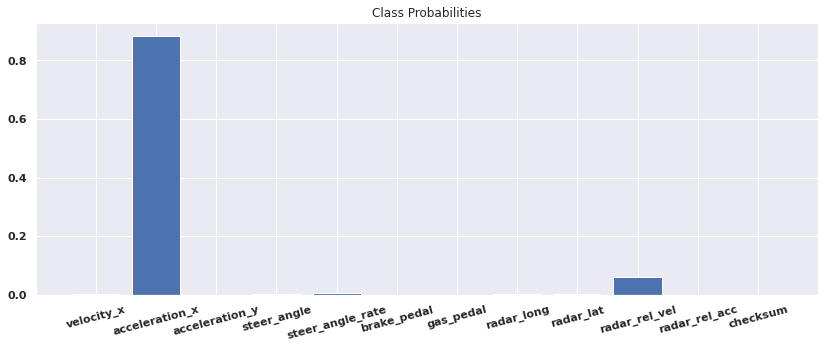

[1.8840134e-03 8.8355434e-01 1.3551116e-04 2.0289123e-03 7.1414411e-03
 9.4655246e-05 1.8379092e-04 3.6673546e-03 1.9988716e-03 6.1581731e-02
 4.8685074e-04 1.2985508e-07]
Analyzing frame_id 361
(30742,) 0111111110110000000000001000000000000000100000000000110010100010 <class 'str'>
[2.6676842e-05 4.1301851e-03 9.0970416e-06 4.1673025e-01 1.8619705e-04
 7.0794107e-05 3.1023745e-05 3.7393346e-01 1.7728707e-03 5.7651396e-05
 2.8648179e-03 2.3266435e-09]
Analyzing frame_id 438
(30742,) 0000000000000010111111111111000000000011111111101100000000000000 <class 'str'>
[2.2034843e-03 2.9797354e-04 5.2233535e-04 1.7473608e-02 4.9555311e-01
 1.0348856e-03 5.4083212e-05 5.3969026e-04 2.8520277e-02 5.6414670e-01
 1.0230953e-04 3.3220278e-08]
Analyzing frame_id 397
(30790,) 0110010101000101111001100111011100000010100000000000000000001101 <class 'str'>


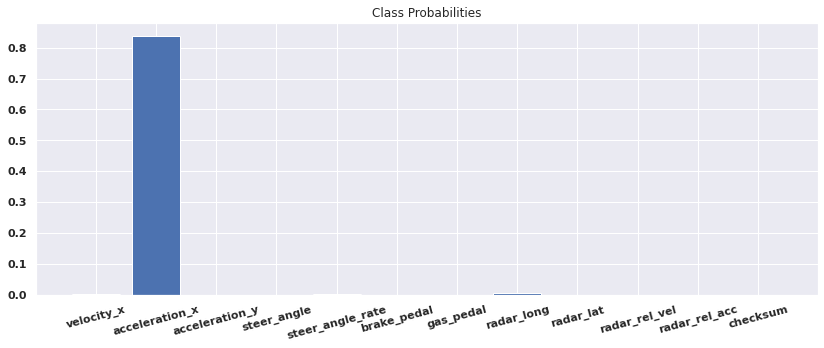

[2.3099780e-03 8.3838516e-01 1.2323449e-05 3.9634109e-04 8.3802146e-04
 8.8486522e-05 3.8235387e-04 5.7673752e-03 4.2581858e-05 7.3276547e-05
 1.4588887e-04 8.4171008e-09]
Analyzing frame_id 451
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'str'>


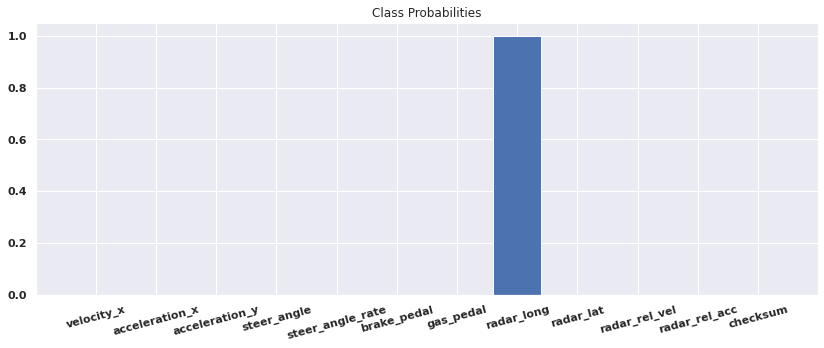

[2.2745939e-05 3.5514120e-06 2.5290251e-04 6.3219666e-04 3.3465851e-05
 1.9098332e-05 1.5535765e-07 9.9937558e-01 6.7191133e-05 1.2686091e-05
 8.7906803e-05 1.2034131e-11]
Analyzing frame_id 398
(30790,) 0000100010010110000001001111000100111000000111100000001000000100 <class 'str'>
[2.2198494e-01 2.2985318e-03 1.7110330e-04 3.2128432e-01 1.9149045e-02
 1.0153731e-01 1.0513687e-02 4.8281550e-03 1.1656340e-01 2.4997492e-03
 1.2228886e-03 7.2531144e-08]
Analyzing frame_id 548
(15401,) 1010100001010010001001000010001000111110100011010111011100110010 <class 'str'>


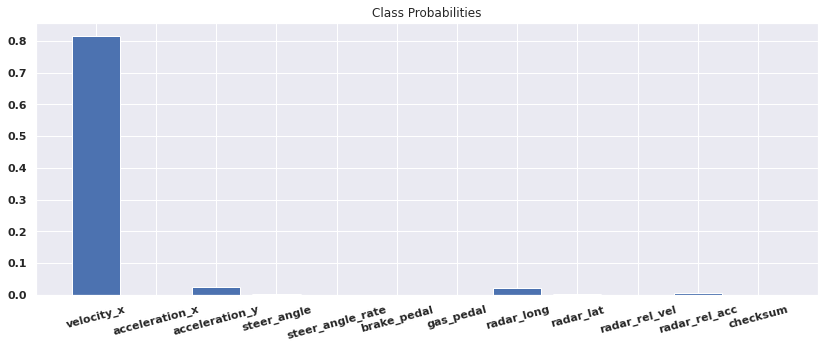

[8.1634569e-01 1.6795157e-05 2.5411457e-02 1.4953315e-03 4.4017183e-05
 2.2938848e-04 7.0065260e-04 2.2314638e-02 1.4452934e-03 1.0393595e-04
 6.2753558e-03 1.2009769e-09]
Analyzing frame_id 574
(15398,) 0000000000000000000000000000000000000000000000000101000000000000 <class 'str'>
[4.00957465e-03 1.77454352e-02 6.92188740e-04 1.48373842e-03
 1.24839365e-01 7.52065420e-01 7.59353638e-02 3.60646844e-03
 1.92861557e-02 2.30561197e-02 3.97702157e-02 1.26059513e-05]
Analyzing frame_id 645
(15398,) 0010000001100011001000000100011100101011000000001101011101110011 <class 'str'>


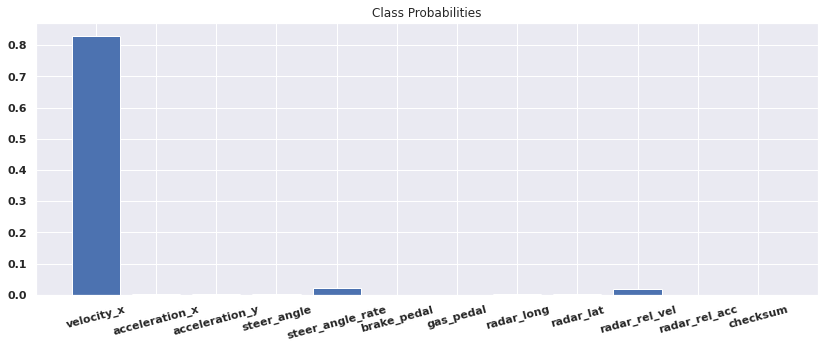

[8.2973927e-01 9.7668171e-04 3.7930310e-03 7.5650215e-04 2.3040414e-02
 4.2526954e-05 3.0846655e-05 2.2930205e-03 1.6570091e-03 1.8820256e-02
 4.7915404e-05 7.1966033e-09]
Analyzing frame_id 523
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'str'>


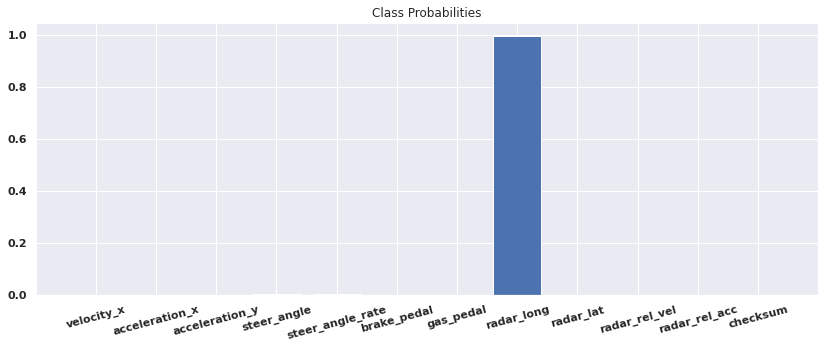

[1.2153162e-06 4.5483759e-08 1.4814000e-05 1.1431575e-03 9.1555715e-04
 5.7738694e-06 4.9306280e-08 9.9603021e-01 6.5369136e-06 2.6406078e-06
 7.0370825e-06 2.7744896e-13]
Analyzing frame_id 1041
(7604,) 0110011100011001000111100000001000110000000100000000000000000000 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 666
(15398,) 0010000000101011001000000111111100010000110001000000011101100001 <class 'str'>
[6.12275124e-01 5.54466248e-03 3.59341502e-03 9.61539149e-03
 4.42326069e-03 3.74495983e-04 9.19550657e-04 1.13459826e-01
 8.17665458e-03 1.29115582e-03 1.37001276e-04 2.00014455e-07]
Analyzing frame_id 855
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'str'>


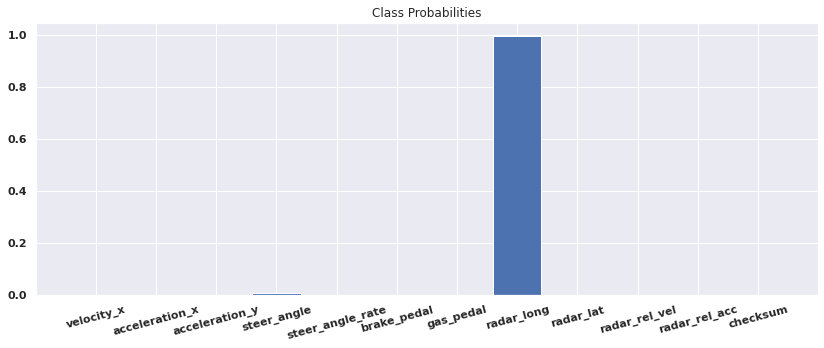

[1.1948565e-04 2.9916043e-06 2.5597215e-04 6.2061250e-03 1.3233621e-05
 1.1892037e-05 1.7000863e-07 9.9580860e-01 5.5144614e-05 8.0518357e-06
 8.2651153e-05 6.4224273e-12]
Analyzing frame_id 634
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'str'>


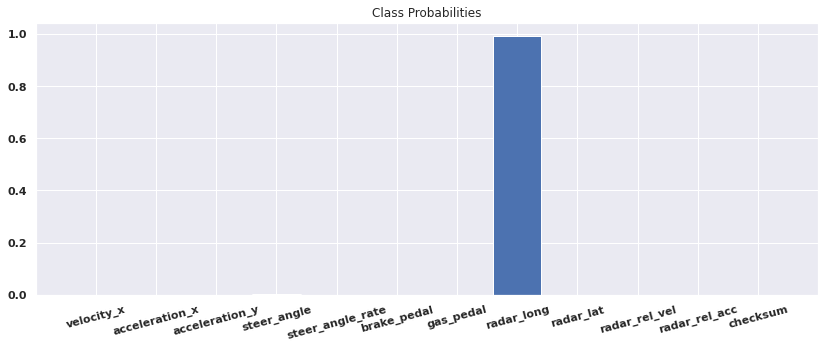

[1.5923381e-04 7.8642734e-06 1.3792515e-04 1.1117458e-03 3.3454300e-05
 2.7831193e-05 6.7161534e-07 9.9323964e-01 2.3844838e-04 4.2337047e-05
 2.9268861e-04 3.1473799e-11]
Analyzing frame_id 566
(15371,) 0011101010000000000000100010011111001011110000011010000001110010 <class 'str'>


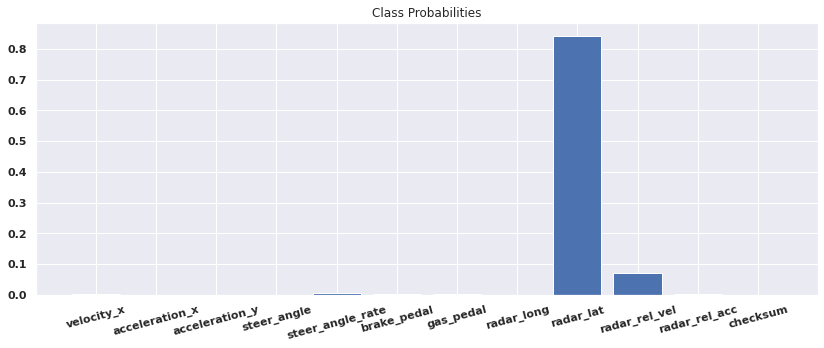

[8.8211894e-04 6.8124741e-06 2.5326014e-04 4.3961471e-05 6.3134432e-03
 1.8018782e-03 1.3439059e-03 1.8981099e-04 8.4297699e-01 7.0444196e-02
 7.4729323e-04 1.7968685e-09]
Analyzing frame_id 1042
(3009,) 1111010000000000000000000000000011111111111111110000100000000000 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 724
(15371,) 0000000000000000000000000000000000000000000000000000001101010000 <class 'str'>
[1.4519393e-03 2.2336841e-04 6.2441230e-03 1.7384648e-02 4.5252356e-05
 1.0521650e-02 1.2232602e-02 4.6897987e-01 3.2109320e-03 3.5776640e-05
 2.3005605e-03 9.6528169e-08]
Analyzing frame_id 689
(15371,) 0000000100000000010001000000000000000000000100000001111000000000 <class 'str'>
[9.3743205e-04 5.0115585e-04 1.7312825e-02 1.7322242e-02 1.1766125e-04
 1.9155443e-02 1.0380897e-01 2.6948333e-01 2.5297701e-03 1.0357340e-04
 1.4872551e-03 4.2647289e-07]
Analyzing frame_id 772
(7699,) 11111110111111101111111011111110111111101111111000000011111

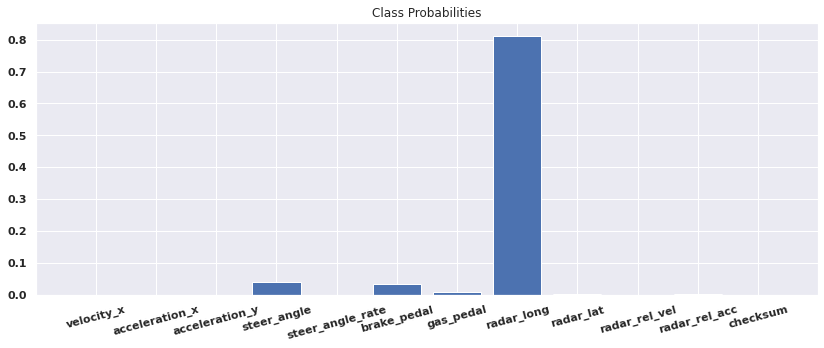

[6.5407157e-04 1.6057491e-04 4.9203634e-04 3.8773268e-02 4.0030198e-05
 3.2940030e-02 7.0858598e-03 8.1178522e-01 1.6053319e-03 4.7921640e-06
 7.7465177e-04 2.1325251e-08]
Analyzing frame_id 776
(7698,) 0000000000000000111111101111111011111110111111100000001100000110 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 674
(15383,) 0000000000000000000000000000000000000000000000000000000000110011 <class 'str'>
[3.71521711e-03 7.25981593e-03 1.37892365e-03 1.26066804e-03
 1.04920864e-01 7.64867306e-01 1.48475885e-01 6.20928407e-03
 9.65252519e-03 1.14464462e-02 9.85264778e-03 9.43809937e-06]
Analyzing frame_id 777
(7698,) 0000000011101110111011101110111011101110111011100000001110110101 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 1105
(3225,) 0000000000000000000000010011000010110000000000000000000010000110 <class 'str'>
Failed to generate predictions, not enough data points.
None
Analyzing frame_id 

In [19]:
frame_id_to_class = {}

import traceback

for frame_id in frame_ids_nissan:
    print(f"Analyzing frame_id {frame_id}")
    try:
        predictions = generate_prediction_from_raw_data_and_frame_id(model, nissan_csv_data, frame_id, start=0,
                                                   length=64, seed=0)
    except:
        traceback.print_exc()
        continue
    predicted_class = np.argmax(predictions)
    if predictions is not None and np.max(predictions) > 0.8:
        frame_id_to_class[frame_id] = predicted_class
    print(predictions)

## Print the detected signals

In [20]:
for frame_id, predicted_class in frame_id_to_class.items():
    print(f"{frame_id}: {labels[predicted_class]} ({predicted_class})")

412: radar_long (7)
723: velocity_x (0)
2: radar_long (7)
658: brake_pedal (5)
682: radar_long (7)
683: acceleration_x (1)
397: acceleration_x (1)
451: radar_long (7)
548: velocity_x (0)
645: velocity_x (0)
523: radar_long (7)
855: radar_long (7)
634: radar_long (7)
566: radar_lat (8)
643: radar_long (7)


## Algorithm 3: extract the exact message encodings of detected signals

The method for this is to fix the message, and progressively mask the message from the right and left, graphing the value of the signal type of interest.

For each Message ID, perform the masking, providing the signal index of interest (i.e. radar_long is index 7 as printed above). Then graph the highest rated encoding to see the decoded signal.

In [35]:
def progressive_mask_on_signal_type(model, csv_file, message_id, signal_indices,
                                    signal_name_labels=labels, plot=True):
    if type(csv_file) == str:
        csv_file = pd.read_csv(csv_file)
    else:
        assert isinstance(csv_file, pd.DataFrame)
    if type(signal_indices) == int:
        signal_indices = [signal_indices]

    masking_from_beginning = []
    masking_from_end = []

    for cutoff_beginning in range(0, 60):
        signal_probs = generate_prediction_from_raw_data_and_frame_id(model,
                                                                      csv_file,
                                                                      message_id,
                                                                      start=cutoff_beginning,
                                                                      length=64 - cutoff_beginning + 1,
                                                                      plot=False)
        masking_from_beginning.append(signal_probs)

    for cutoff_end in range(64, 4, -1):
        signal_probs = generate_prediction_from_raw_data_and_frame_id(model,
                                                                      csv_file,
                                                                      message_id,
                                                                      start=0,
                                                                      length=cutoff_end,
                                                                      plot=False)
        masking_from_end.append(signal_probs)

    if plot:
        fig, axs = plt.subplots(2*len(signal_indices))
        fig.set_figheight(9 * len(signal_indices))
        fig.set_figwidth(16)
        for i, signal_index in enumerate(signal_indices):
            axs[i*2].plot(list(range(60)), [probs[signal_index] for probs in masking_from_beginning])
            axs[i*2+1].plot(list(range(64, 4, -1)), [probs[signal_index] for probs in masking_from_end])
            axs[i*2].set_title(f'Masking {signal_name_labels[signal_index]} ignoring before beginning index')
            axs[i*2+1].set_title(f'Masking {signal_name_labels[signal_index]} ignoring after end index')
    return masking_from_beginning, masking_from_end

In [36]:
def score_continuities_and_switching(csv_data, msg_id, starts, ends, data_size=None):
    if data_size is None:
        data_size = int(csv_data[csv_data["MessageID"] == msg_id]["MessageLength"].iloc[0] * 8)
        print(f"Auto detecting data size as {data_size} bits")
    scores = []
    for start in starts:
        for end in ends:
            if end <= start:
                continue
            if start - (64 - data_size) < 0:
                continue
            for signed in [False, True]:
                xs, ys = plot_message_id(csv_data,
                                        msg_id, # message id
                                        convert_to_big_endian_start(start - (64 - data_size)),
                                        end - start,
                                        byteorder='big',
                                        signed=signed,
                                        plot_fxn=None)
                signal_values = ys[0]
                continuity_score = 1/(np.count_nonzero(np.diff(signal_values) > 0.1 * np.ptp(signal_values)) + 1)
                switch_score = np.count_nonzero(np.diff(signal_values))
                scores.append(
                    {
                        'continuity_score': continuity_score,
                        'switch_score': switch_score,
                        'position': start,
                        'end': end,
                        'length': end-start,
                        'byteorder': 'big',
                        'signed': signed
                    }
                )
                xs, ys = plot_message_id(csv_data,
                                        msg_id, # message id
                                        start - (64 - data_size),
                                        end - start,
                                        byteorder='little',
                                        signed=signed,
                                        plot_fxn=None)
                signal_values = ys[0]
                continuity_score = 1/(np.count_nonzero(np.diff(signal_values) > 0.1 * np.ptp(signal_values)) + 1)
                switch_score = np.count_nonzero(np.diff(signal_values))
                scores.append(
                    {
                        'continuity_score': continuity_score,
                        'switch_score': switch_score,
                        'position': start,
                        'end': end,
                        'length': end-start,
                        'byteorder': 'little',
                        'signed': signed
                    }
                )
    scores_df = pd.DataFrame(scores)
    if len(scores_df):
        scores_df.sort_values(by=['continuity_score', 'switch_score', 'length'], inplace=True, ascending=[False, False, True])
    return scores_df

## Evaluate radar_long

(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'str'>
(30796,) 1100000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 1100000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 1101000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 1101100000000000000000000000000011111111100000000000001100011111 <class 'numpy.str_'>
(30796,) 000000000000000000000000000000001111111110000000

(30796,) 1101111110010010100110111011100010110100000100000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000001100011111 <class 'numpy.str_'>
(30796,) 1101111110010010100110111011100010110100000100000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000001100011111 <class 'numpy.str_'>
(30796,) 1101111110010010100110111011100010110100000100000000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000001100011111 <class 'numpy.str_'>
(30796,) 1101111110010010100110111011100010110100000100100000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000001100011111 <class 'numpy.str_'>
(30796,) 1101111110010010100110111011100010110100000100110000001100011111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000001100011111 <class 'numpy.str_'>
(30796,) 11011111100100101001101110111000101101000

(30796,) 0000000000000000000000000000000011111101111110010010100110111011 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011110000000000000000000000000000 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011111011111100100101001101110111 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011100000000000000000000000000000 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011110111111001001010011011101110 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011000000000000000000000000000000 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011101111110010010100110111011100 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000010000000000000000000000000000000 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000011011111100100101001101110111000 <class 'numpy.str_'>
(30796,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(30796,) 00000000000000000000000000000001101111110

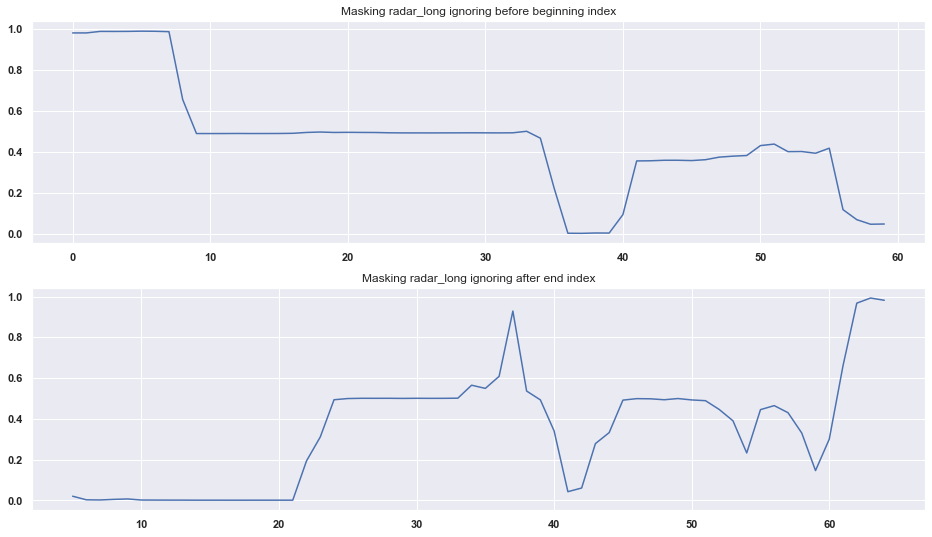

In [300]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 412, [7])

In [301]:
score_continuities_and_switching(nissan_csv_data, 412, [0, 3, 7, 33, 41], [37, 62, 63], data_size=48)

(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'str'>
(30794,) 1100000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 1100000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 1101000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 1101100000000000000000001110011011111111000000100000011101111010 <class 'numpy.str_'>
(30794,) 000000000000000000000000111001101111111100000010

(30794,) 1101111110010010100110111011100010110100000100100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000000000000000000000000000100000011101111010 <class 'numpy.str_'>
(30794,) 1101111110010010100110111011100010110100000100100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000000000000000000000000000100000011101111010 <class 'numpy.str_'>
(30794,) 1101111110010010100110111011100010110100000100100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000000000000000000000000000100000011101111010 <class 'numpy.str_'>
(30794,) 1101111110010010100110111011100010110100000100100000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000000000000000000000000000000000011101111010 <class 'numpy.str_'>
(30794,) 1101111110010010100110111011100010110100000100110000011101111010 <class 'numpy.str_'>
(30794,) 0000000000000000000000000000000000000000000000000000011101111010 <class 'numpy.str_'>
(30794,) 11011111100100101001101110111000101101000

(30794,) 0000000000000000000000001110011011111101111110010010100110111011 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011110000000000000000000000000000 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011111011111100100101001101110111 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011100000000000000000000000000000 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011110111111001001010011011101110 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011000000000000000000000000000000 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011101111110010010100110111011100 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011010000000000000000000000000000000 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011011011111100100101001101110111000 <class 'numpy.str_'>
(30794,) 0000000000000000000000001110011000000000000000000000000000000000 <class 'numpy.str_'>
(30794,) 00000000000000000000000011100111101111110

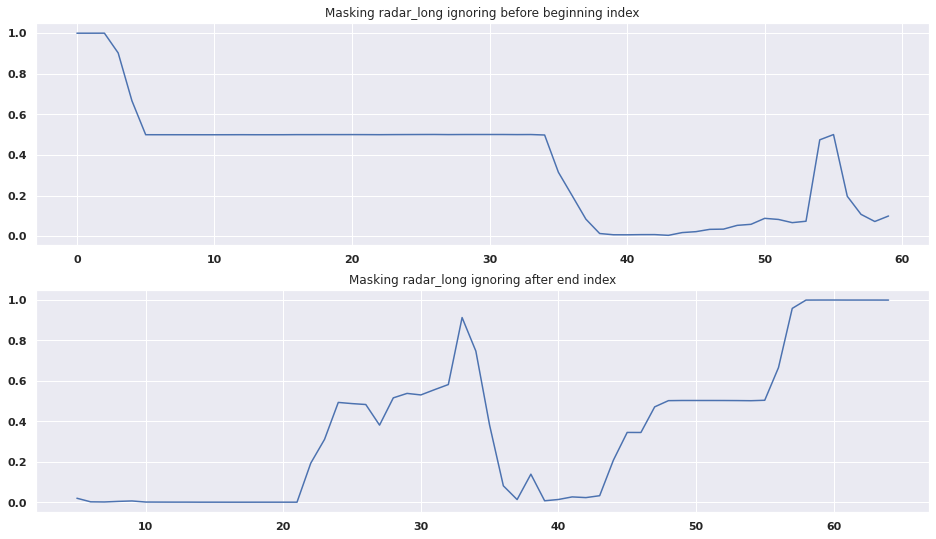

In [180]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 2, [7])

In [233]:
score_continuities_and_switching(nissan_csv_data, 2, [0, 3, 5, 34, 54, 55], [32, 48, 55, 57, 58])

Auto detecting data size as 40 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
14,1.000000,15576,34,58,24,big,True
1,1.000000,8350,34,48,14,little,False
3,1.000000,8350,34,48,14,little,True
16,1.000000,0,54,55,1,big,False
17,1.000000,0,54,55,1,little,False
18,1.000000,0,54,55,1,big,True
19,1.000000,0,54,55,1,little,True
12,0.029412,15576,34,58,24,big,False
8,0.029412,12190,34,57,23,big,False
10,0.029412,12190,34,57,23,big,True


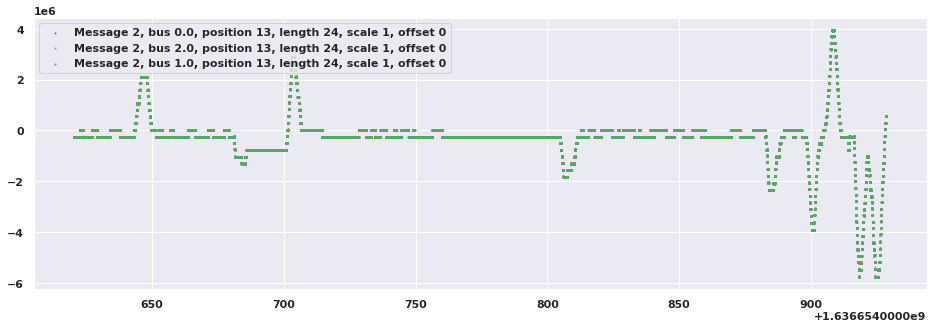

([12         1.636655e+09
  52         1.636655e+09
  129        1.636655e+09
  190        1.636655e+09
  281        1.636655e+09
                 ...     
  1954960    1.636655e+09
  1955020    1.636655e+09
  1955080    1.636655e+09
  1955149    1.636655e+09
  1955228    1.636655e+09
  Name: Time, Length: 30794, dtype: float64,
  13         1.636655e+09
  51         1.636655e+09
  128        1.636655e+09
  189        1.636655e+09
  282        1.636655e+09
                 ...     
  1954959    1.636655e+09
  1955019    1.636655e+09
  1955079    1.636655e+09
  1955148    1.636655e+09
  1955229    1.636655e+09
  Name: Time, Length: 30794, dtype: float64,
  16         1.636655e+09
  53         1.636655e+09
  130        1.636655e+09
  191        1.636655e+09
  327        1.636655e+09
                 ...     
  1954963    1.636655e+09
  1955025    1.636655e+09
  1955083    1.636655e+09
  1955179    1.636655e+09
  1955236    1.636655e+09
  Name: Time, Length: 30794, dtype: float64],
 [12  

In [232]:
plt.figure(figsize=(16, 5))
start_position = 34
end_position = 58
data_size = 40
plot_message_id(nissan_csv_data,
                2, # message id
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=True)

### ^ Found one radar-like signal. Cannot verify yet.

(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'str'>
(15398,) 1100000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1100000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101100000000010100000101110100000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 000000000000001010000010111010000000000000000000

(15398,) 1101111110010010100110111011100010110100000100000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100110000011100011111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000011100011111 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 0000000000000010100000101110100000001101111110010010100110111011 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000011011111100100101001101110111 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100001101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100011011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 0000000000000010100000101110100000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 00000000000000101000001011101001101111110

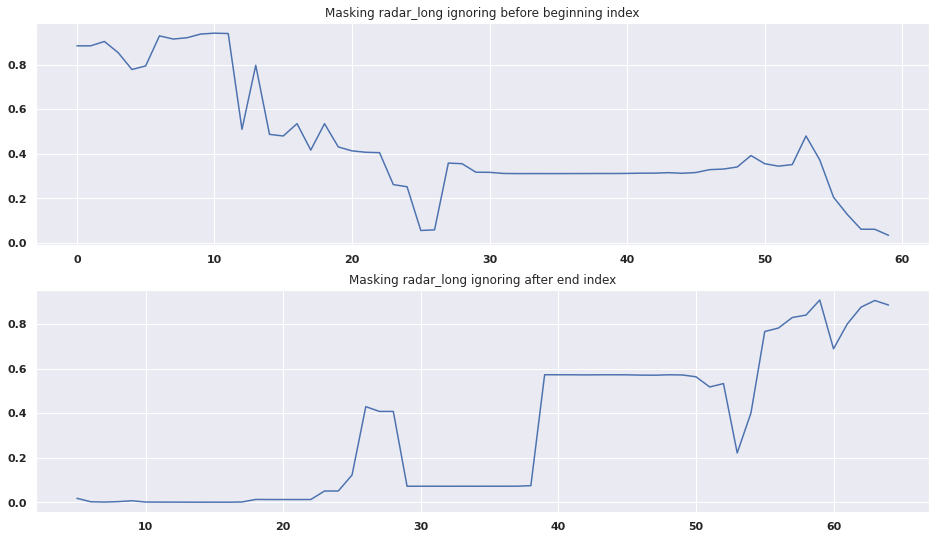

In [182]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 682, [7])

In [257]:
df = score_continuities_and_switching(nissan_csv_data, 682, [0, 2, 6, 11, 13, 27], [26, 28, 39, 52, 59, 63])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
132,1.0,15397,27,59,32,big,False
133,1.0,15397,27,59,32,little,False
134,1.0,15397,27,59,32,big,True
135,1.0,15397,27,59,32,little,True
136,1.0,15397,27,63,36,big,False
138,1.0,15397,27,63,36,big,True
113,1.0,15397,13,59,46,little,False
115,1.0,15397,13,59,46,little,True
89,1.0,15397,11,59,48,little,False
91,1.0,15397,11,59,48,little,True


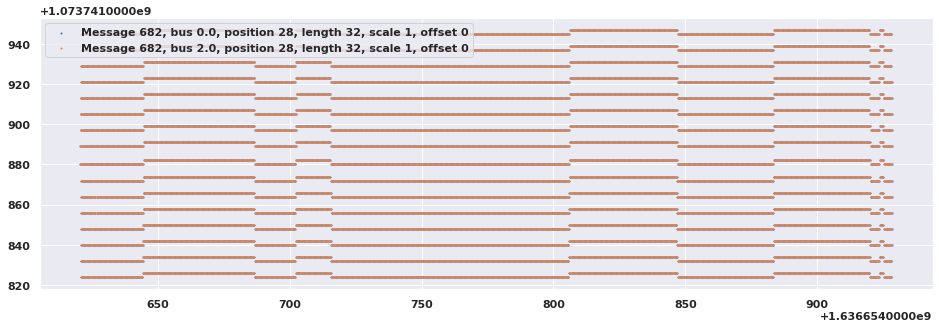

([32         1.636655e+09
  151        1.636655e+09
  317        1.636655e+09
  443        1.636655e+09
  536        1.636655e+09
                 ...     
  1954719    1.636655e+09
  1954837    1.636655e+09
  1954942    1.636655e+09
  1955062    1.636655e+09
  1955208    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  33         1.636655e+09
  150        1.636655e+09
  316        1.636655e+09
  444        1.636655e+09
  535        1.636655e+09
                 ...     
  1954718    1.636655e+09
  1954838    1.636655e+09
  1954941    1.636655e+09
  1955061    1.636655e+09
  1955207    1.636655e+09
  Name: Time, Length: 15398, dtype: float64],
 [32         1073741880
  151        1073741889
  317        1073741897
  443        1073741905
  536        1073741913
                ...    
  1954719    1073741889
  1954837    1073741897
  1954942    1073741905
  1955062    1073741913
  1955208    1073741921
  Name: Message, Length: 15398, dtype: int64,
  33         1073741880
  1

In [266]:
plt.figure(figsize=(16, 5))
start_position = 27
end_position = 59
data_size = 64
message_id = 682
plot_message_id(nissan_csv_data,
                message_id,
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=False)

(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'str'>
(30742,) 1100000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 1100000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101100000000000000000000000000001100100000000001111111100100111 <class 'numpy.str_'>
(30742,) 000000000000000000000000000000000110010000000000

(30742,) 1101111110010010100110111011100010110100000100001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101111110010010100110111011100010110100000100001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101111110010010100110111011100010110100000100001111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101111110010010100110111011100010110100000100101111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000001111111100100111 <class 'numpy.str_'>
(30742,) 1101111110010010100110111011100010110100000100111111111100100111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000001111111100100111 <class 'numpy.str_'>
(30742,) 11011111100100101001101110111000101101000

(30742,) 0000000000000000000000000000000001101101111110010010100110111011 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100000000000000000000000000000 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001111011111100100101001101110111 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001100000000000000000000000000000 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001110111111001001010011011101110 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001000000000000000000000000000000 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000001101111110010010100110111011100 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000011011111100100101001101110111000 <class 'numpy.str_'>
(30742,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(30742,) 00000000000000000000000000000001101111110

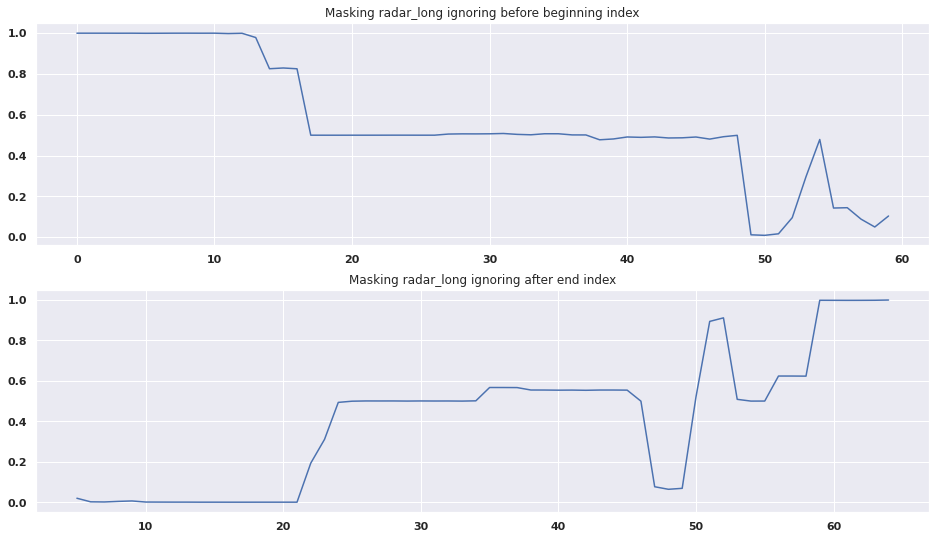

In [183]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 451, [7])

In [238]:
df = score_continuities_and_switching(nissan_csv_data, 451, [12, 13, 17, 48], [24, 45, 46, 51, 52])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
0,1.0,0,12,24,12,big,False
1,1.0,0,12,24,12,little,False
2,1.0,0,12,24,12,big,True
3,1.0,0,12,24,12,little,True
4,1.0,0,12,45,33,big,False
5,1.0,0,12,45,33,little,False
6,1.0,0,12,45,33,big,True
7,1.0,0,12,45,33,little,True
8,1.0,0,12,46,34,big,False
9,1.0,0,12,46,34,little,False


(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'str'>
(15044,) 1100000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 1100000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 1101000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 1101100000000000100000000010000001000011000101001011101011010000 <class 'numpy.str_'>
(15044,) 000000000000000010000000001000000100001100010100

(15044,) 1101111110010010100110111011100010110100000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000000000000000000000000000000001001011101011010000 <class 'numpy.str_'>
(15044,) 1101111110010010100110111011100010110100000101001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000000000000000000000000000000001001011101011010000 <class 'numpy.str_'>
(15044,) 1101111110010010100110111011100010110100000100001011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000000000000000000000000000000000001011101011010000 <class 'numpy.str_'>
(15044,) 1101111110010010100110111011100010110100000100101011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000000000000000000000000000000000001011101011010000 <class 'numpy.str_'>
(15044,) 1101111110010010100110111011100010110100000100111011101011010000 <class 'numpy.str_'>
(15044,) 0000000000000000000000000000000000000000000000001011101011010000 <class 'numpy.str_'>
(15044,) 11011111100100101001101110111000101101000

(15044,) 0000000000000000100000000010000001001101111110010010100110111011 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000000000000000000000000000000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001011011111100100101001101110111 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000000000000000000000000000000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001110111111001001010011011101110 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001000000000000000000000000000000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000001101111110010010100110111011100 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000000000000000000000000000000000000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000011011111100100101001101110111000 <class 'numpy.str_'>
(15044,) 0000000000000000100000000010000000000000000000000000000000000000 <class 'numpy.str_'>
(15044,) 00000000000000001000000000100001101111110

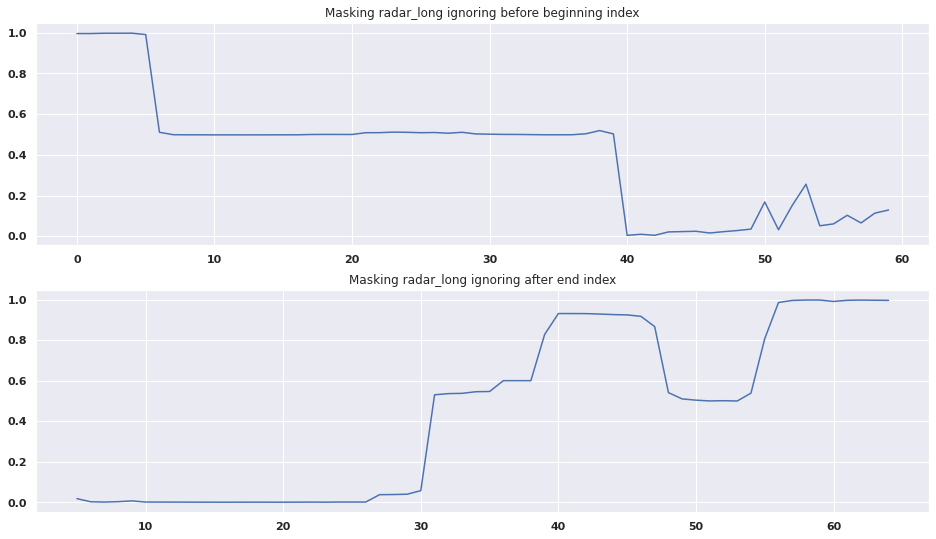

In [184]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 523, [7])

In [258]:
df = score_continuities_and_switching(nissan_csv_data, 523, [5, 6, 39], [31, 40, 46, 56])
df.head(10)

Auto detecting data size as 48 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
9,0.000880,15043,39,56,17,little,False
11,0.000879,15043,39,56,17,little,True
0,0.000133,15043,39,40,1,big,False
1,0.000133,15043,39,40,1,little,False
2,0.000133,15043,39,40,1,big,True
3,0.000133,15043,39,40,1,little,True
4,0.000133,15043,39,46,7,big,False
5,0.000133,15043,39,46,7,little,False
6,0.000133,15043,39,46,7,big,True
7,0.000133,15043,39,46,7,little,True


(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'str'>
(15398,) 1100000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 1100000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 1101000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 1101100000000000000000000011010101000110001110100000101100000111 <class 'numpy.str_'>
(15398,) 000000000000000000000000001101010100011000111010

(15398,) 1101111110010010100110111011100010110100000110100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000010100000101100000111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000100000101100000111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000100000101100000111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000101100000111 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100110000101100000111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000101100000111 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 0000000000000000000000000011010101001101111110010010100110111011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101011011111100100101001101110111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010101101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010111011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000011010100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 00000000000000000000000000110101101111110

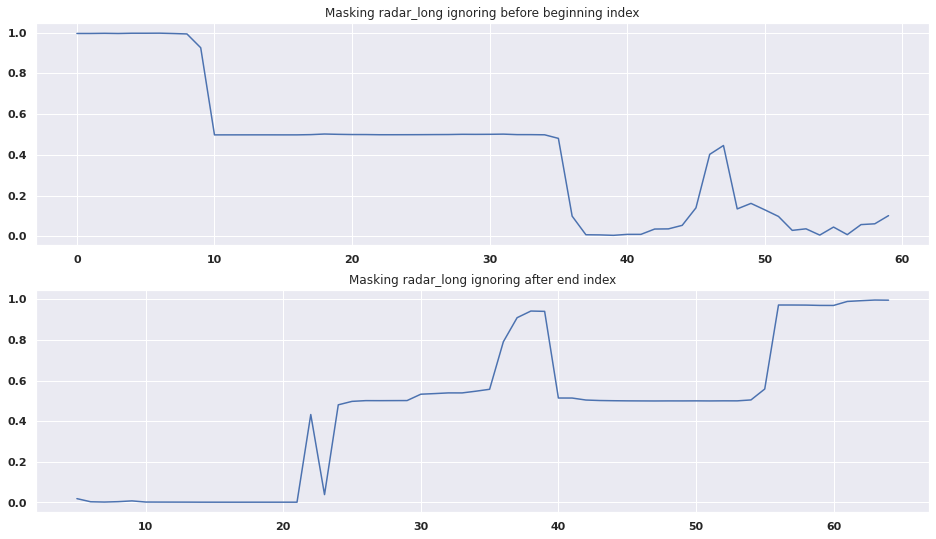

In [185]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 855, [7])

In [249]:
df = score_continuities_and_switching(nissan_csv_data, 855, [8, 10, 35, 47], [22, 24, 35, 39, 40, 56])
df.head(10)

Auto detecting data size as 40 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
9,0.000332,13049,35,56,21,little,False
11,0.000332,13049,35,56,21,little,True
13,0.000332,12908,47,56,9,little,False
15,0.000332,12908,47,56,9,little,True
12,0.000296,12908,47,56,9,big,False
14,0.000296,12908,47,56,9,big,True
8,0.000136,13049,35,56,21,big,False
10,0.000136,13049,35,56,21,big,True
4,0.000136,12612,35,40,5,big,False
5,0.000136,12612,35,40,5,little,False


(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'str'>
(15371,) 1100000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1100000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101100000000001101011010101001010010000000000000000011100010011 <class 'numpy.str_'>
(15371,) 000000000000000110101101010100101001000000000000

(15371,) 1101111110010010100110111011100010110100000100000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100000000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100100000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000000000011100010011 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100110000011100010011 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000000000011100010011 <class 'numpy.str_'>
(15371,) 11011111100100101001101110111000101101000

(15371,) 0000000000000001101011010101001010011101111110010010100110111011 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010010000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010011011111100100101001101110111 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010110111111001001010011011101110 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001011101111110010010100110111011100 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001010000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001011011111100100101001101110111000 <class 'numpy.str_'>
(15371,) 0000000000000001101011010101001000000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 00000000000000011010110101010011101111110

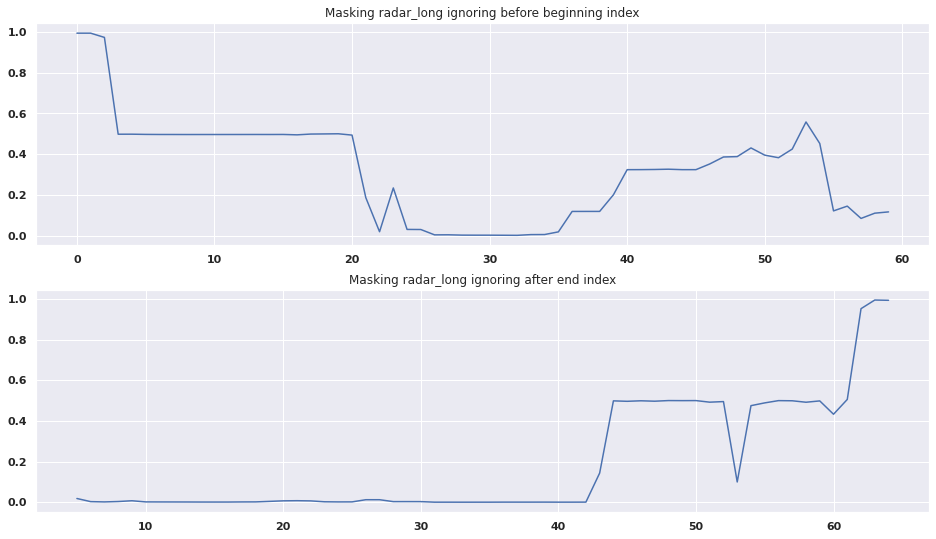

In [144]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 634, [7])

In [248]:
df = score_continuities_and_switching(nissan_csv_data, 634, [2, 3, 20], [44, 52, 54])
df.head(10)

Auto detecting data size as 56 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
9,0.013889,8814,20,54,34,little,False
11,0.013889,8814,20,54,34,little,True
5,0.013889,6585,20,52,32,little,False
7,0.013889,6585,20,52,32,little,True
1,0.006289,6509,20,44,24,little,False
3,0.006289,6509,20,44,24,little,True
6,0.001779,6585,20,52,32,big,True
2,0.001779,6509,20,44,24,big,True
8,0.001770,8814,20,54,34,big,False
10,0.001770,8814,20,54,34,big,True


(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'str'>
(15398,) 1100000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 1100000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 1101000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 1101100000000000000000000000000000100010111000000000000000000000 <class 'numpy.str_'>
(15398,) 000000000000000000000000000000000010001011100000

(15398,) 1101111110010010100110111011100010110100000100000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100110000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 0000000000000000000000000000000000101101111110010010100110111011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000111011111100100101001101110111 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000001101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000011011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 00000000000000000000000000000001101111110

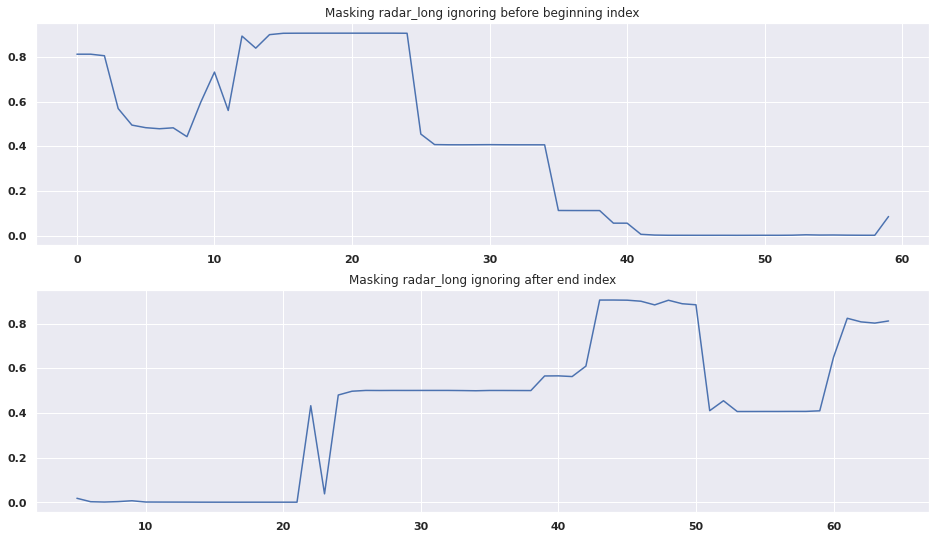

In [186]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 643, [7])

In [247]:
df = score_continuities_and_switching(nissan_csv_data, 643, [0, 12, 24, 34], [22, 24, 43, 50, 61])
df.head(10)

Auto detecting data size as 40 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
0,1.0,0,24,43,19,big,False
1,1.0,0,24,43,19,little,False
2,1.0,0,24,43,19,big,True
3,1.0,0,24,43,19,little,True
4,1.0,0,24,50,26,big,False
5,1.0,0,24,50,26,little,False
6,1.0,0,24,50,26,big,True
7,1.0,0,24,50,26,little,True
8,1.0,0,24,61,37,big,False
9,1.0,0,24,61,37,little,False


## Evaluate radar_lat

(15371,) 0011101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111001011110000011010000001110010 <class 'str'>
(15371,) 1111101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 1101101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 0001101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 1101101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 0000101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 1101101010000000000000100010011111001011110000011010000001110010 <class 'numpy.str_'>
(15371,) 000000101000000000000010001001111100101111000001

(15371,) 1101111110010010100110111011100010110100000100011010000001110010 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000011010000001110010 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100011010000001110010 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000011010000001110010 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100011010000001110010 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000011010000001110010 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100111010000001110010 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000011010000001110010 <class 'numpy.str_'>
(15371,) 1101111110010010100110111011100010110100000100111010000001110010 <class 'numpy.str_'>
(15371,) 0000000000000000000000000000000000000000000000001010000001110010 <class 'numpy.str_'>
(15371,) 11011111100100101001101110111000101101000

(15371,) 0011101010000000000000100010011111001101111110010010100110111011 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111011011111100100101001101110111 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111110111111001001010011011101110 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111101111110010010100110111011100 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011110000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011111011111100100101001101110111000 <class 'numpy.str_'>
(15371,) 0011101010000000000000100010011100000000000000000000000000000000 <class 'numpy.str_'>
(15371,) 00111010100000000000001000100111101111110

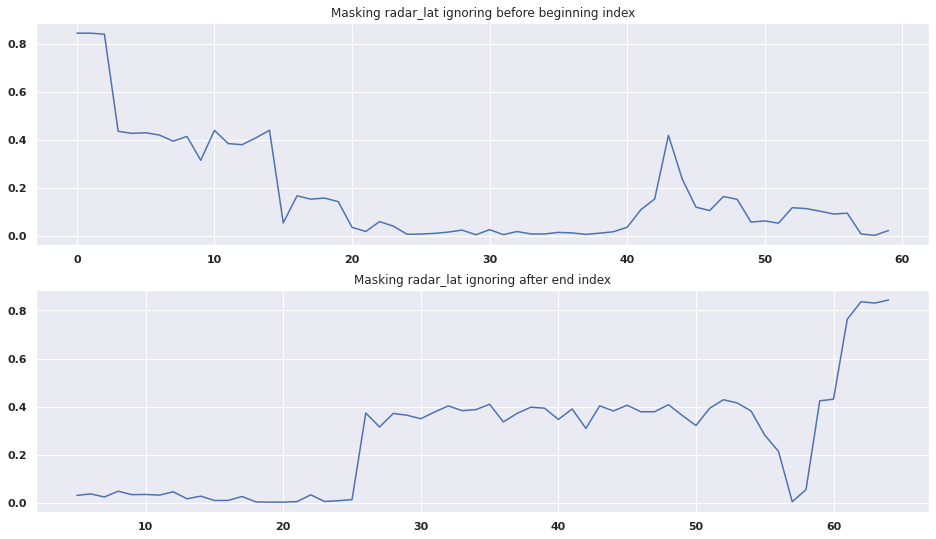

In [187]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 566, [8])

In [259]:
df = score_continuities_and_switching(nissan_csv_data, 566, [0, 2, 3, 14, 43], [26, 52, 59, 60, 62])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
89,1.0,15370,43,60,17,little,False
91,1.0,15370,43,60,17,little,True
73,1.0,15370,14,60,46,little,False
75,1.0,15370,14,60,46,little,True
53,1.0,15370,3,60,57,little,False
55,1.0,15370,3,60,57,little,True
33,1.0,15370,2,60,58,little,False
35,1.0,15370,2,60,58,little,True
13,1.0,15370,0,60,60,little,False
15,1.0,15370,0,60,60,little,True


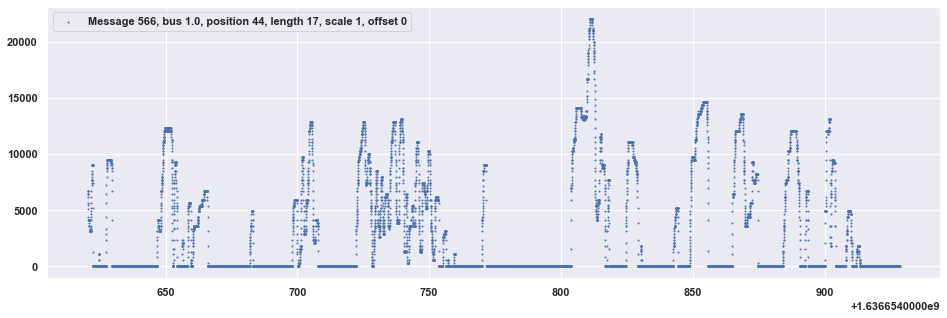

([79         1.636655e+09
  258        1.636655e+09
  362        1.636655e+09
  490        1.636655e+09
  587        1.636655e+09
                 ...     
  1954754    1.636655e+09
  1954871    1.636655e+09
  1954981    1.636655e+09
  1955144    1.636655e+09
  1955263    1.636655e+09
  Name: Time, Length: 15371, dtype: float64],
 [79         6663
  258        6664
  362        6409
  490        6666
  587        6411
             ... 
  1954754      13
  1954871      14
  1954981      15
  1955144       0
  1955263       1
  Name: Message, Length: 15371, dtype: int64])

In [339]:
plt.figure(figsize=(16, 5))
start_position = 43
end_position = 60
data_size = 64
message_id = 566
plot_message_id(nissan_csv_data,
                message_id,
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=True)

## Evaluate acceleration

(30790,) 0110010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000010100000000000000000001101 <class 'str'>
(30790,) 1110010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 0010010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 1100010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 0000010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 1101010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 0000010101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 1101110101000101111001100111011100000010100000000000000000001101 <class 'numpy.str_'>
(30790,) 000001010100010111100110011101110000001010000000

(30790,) 1101111110010010100110111011100010110100000100000000000000001101 <class 'numpy.str_'>
(30790,) 0000000000000000000000000000000000000000000000000000000000001101 <class 'numpy.str_'>
(30790,) 1101111110010010100110111011100010110100000100000000000000001101 <class 'numpy.str_'>
(30790,) 0000000000000000000000000000000000000000000000000000000000001101 <class 'numpy.str_'>
(30790,) 1101111110010010100110111011100010110100000100000000000000001101 <class 'numpy.str_'>
(30790,) 0000000000000000000000000000000000000000000000000000000000001101 <class 'numpy.str_'>
(30790,) 1101111110010010100110111011100010110100000100100000000000001101 <class 'numpy.str_'>
(30790,) 0000000000000000000000000000000000000000000000000000000000001101 <class 'numpy.str_'>
(30790,) 1101111110010010100110111011100010110100000100110000000000001101 <class 'numpy.str_'>
(30790,) 0000000000000000000000000000000000000000000000000000000000001101 <class 'numpy.str_'>
(30790,) 11011111100100101001101110111000101101000

(30790,) 0110010101000101111001100111011100001101111110010010100110111011 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000000000000000000000000000000 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100011011111100100101001101110111 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000000000000000000000000000000 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100110111111001001010011011101110 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000000000000000000000000000000 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011101101111110010010100110111011100 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000000000000000000000000000000 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011111011111100100101001101110111000 <class 'numpy.str_'>
(30790,) 0110010101000101111001100111011100000000000000000000000000000000 <class 'numpy.str_'>
(30790,) 01100101010001011110011001110111101111110

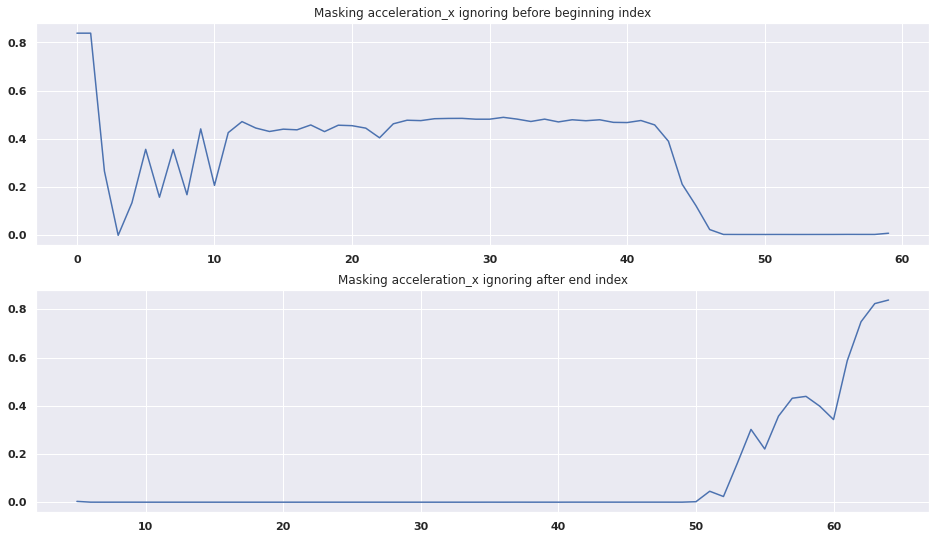

In [108]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 397, [1])

In [260]:
df = score_continuities_and_switching(nissan_csv_data, 397, [0, 12, 41], [58, 63])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
13,1.000,30789,12,63,51,little,False
15,1.000,30789,12,63,51,little,True
5,1.000,30789,0,63,63,little,False
7,1.000,30789,0,63,63,little,True
20,1.000,2142,41,63,22,big,False
21,1.000,2142,41,63,22,little,False
22,1.000,2142,41,63,22,big,True
23,1.000,2142,41,63,22,little,True
8,0.125,30789,12,58,46,big,False
10,0.125,30789,12,58,46,big,True


(15398,) 1111111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011100000001000011000000001100100 <class 'str'>
(15398,) 1111111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 0011111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 0001111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 0000111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111111010111110111000000000011100000001000011000000001100100 <class 'numpy.str_'>
(15398,) 000001111101011111011100000000001110000000100001

(15398,) 1101111110010010100110111011100010110100000100011000000001100100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100011000000001100100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100011000000001100100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100111000000001100100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000011000000001100100 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100111000000001100100 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001000000001100100 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 1111111111010111110111000000000011101101111110010010100110111011 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011111011111100100101001101110111 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000010000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000011011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 1111111111010111110111000000000000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 11111111110101111101110000000001101111110

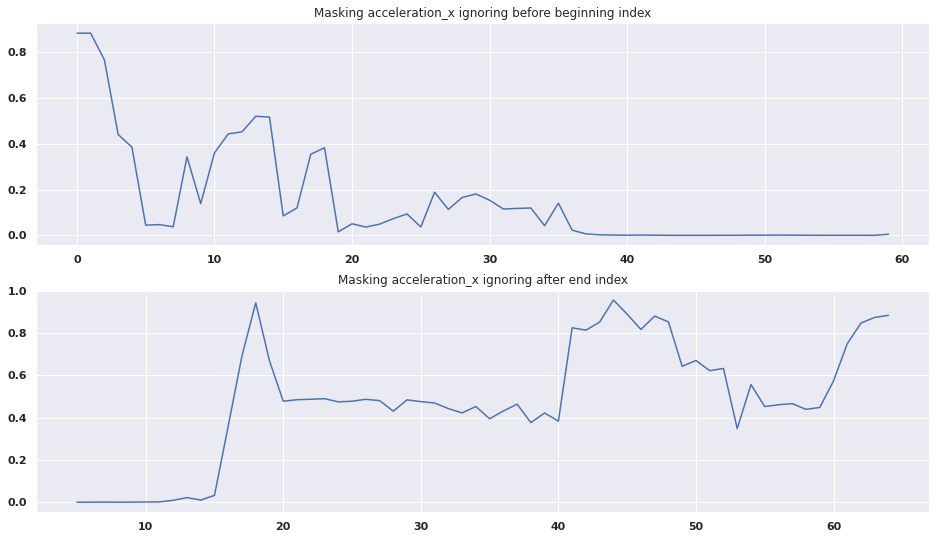

In [188]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 683, [1])

In [261]:
df = score_continuities_and_switching(nissan_csv_data, 683, [0, 1, 13, 14], [18, 20, 41, 44, 63])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
30,0.200000,12676,1,41,40,big,True
35,0.142857,12902,1,44,43,little,True
15,0.142857,12902,0,44,44,little,True
75,0.142857,12809,14,44,30,little,True
55,0.142857,12809,13,44,31,little,True
36,0.023256,14426,1,63,62,big,False
38,0.023256,14426,1,63,62,big,True
16,0.023256,14426,0,63,63,big,False
18,0.023256,14426,0,63,63,big,True
32,0.023256,12902,1,44,43,big,False


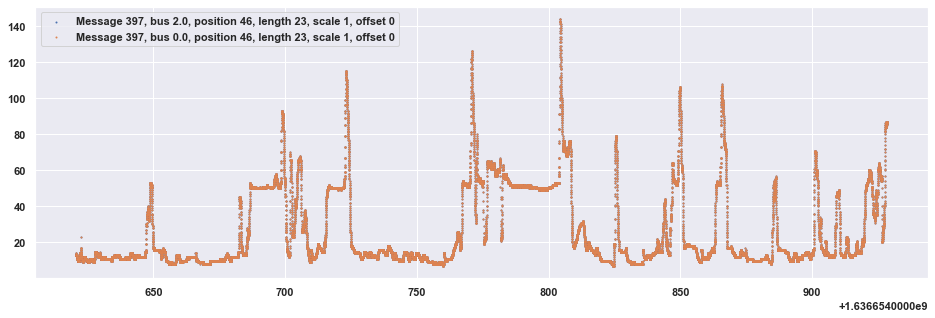

([39         1.636655e+09
  83         1.636655e+09
  158        1.636655e+09
  224        1.636655e+09
  319        1.636655e+09
                 ...     
  1954964    1.636655e+09
  1955037    1.636655e+09
  1955084    1.636655e+09
  1955170    1.636655e+09
  1955250    1.636655e+09
  Name: Time, Length: 30790, dtype: float64,
  40         1.636655e+09
  84         1.636655e+09
  159        1.636655e+09
  223        1.636655e+09
  320        1.636655e+09
                 ...     
  1954965    1.636655e+09
  1955038    1.636655e+09
  1955085    1.636655e+09
  1955169    1.636655e+09
  1955251    1.636655e+09
  Name: Time, Length: 30790, dtype: float64],
 [39         13
  83         13
  158        13
  224        13
  319        13
             ..
  1954964    86
  1955037    86
  1955084    86
  1955170    86
  1955250    85
  Name: Message, Length: 30790, dtype: int64,
  40         13
  84         13
  159        13
  223        13
  320        13
             ..
  1954965    86
  1

In [340]:
plt.figure(figsize=(16, 5))
start_position = 41
end_position = 64
data_size = 64
plot_message_id(nissan_csv_data,
                397, # message id
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=True)

## Evaluate brake pedals

(15398,) 1000001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110101111101000000001001100000011 <class 'str'>
(15398,) 1100001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 0000001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 1100001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 0000001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 1101001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 0000001101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 1101101101001000000001100111111110101111101000000001001100000011 <class 'numpy.str_'>
(15398,) 000000110100100000000110011111111010111110100000

(15398,) 1101111110010010100110111011100010110100000100000001001100000011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000001001100000011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000001001100000011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000001001100000011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100000001001100000011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000001001100000011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100100001001100000011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000001001100000011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100110001001100000011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000001001100000011 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 1000001101001000000001100111111110101101111110010010100110111011 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110111011111100100101001101110111 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111111101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111110000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111111011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 1000001101001000000001100111111100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 10000011010010000000011001111111101111110

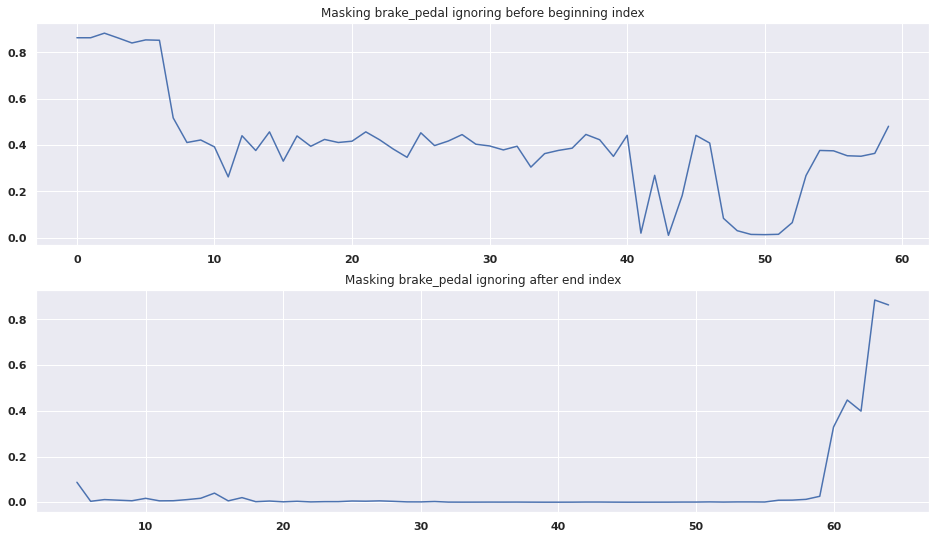

In [57]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 658, 5)

In [262]:
df = score_continuities_and_switching(nissan_csv_data, 658, [0, 6, 40, 45, 46], [60, 61, 63, 64])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
76,1.0,15397,46,64,18,big,False
78,1.0,15397,46,64,18,big,True
60,1.0,15397,45,64,19,big,False
62,1.0,15397,45,64,19,big,True
44,1.0,15397,40,64,24,big,False
46,1.0,15397,40,64,24,big,True
72,1.0,8387,46,63,17,big,False
74,1.0,8387,46,63,17,big,True
56,1.0,8387,45,63,18,big,False
58,1.0,8387,45,63,18,big,True


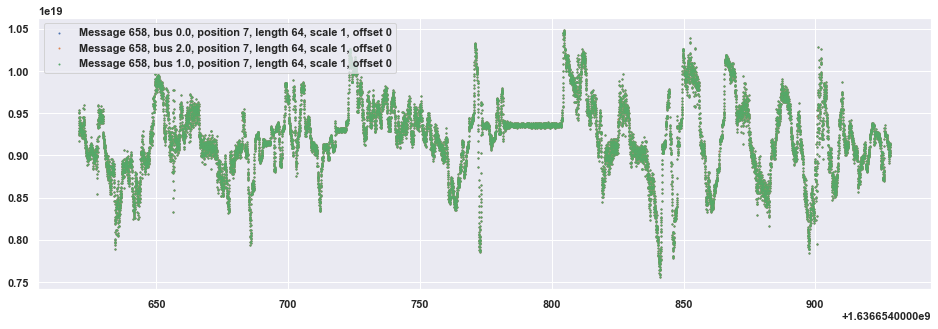

([27         1.636655e+09
  146        1.636655e+09
  306        1.636655e+09
  439        1.636655e+09
  534        1.636655e+09
                 ...     
  1954710    1.636655e+09
  1954834    1.636655e+09
  1954939    1.636655e+09
  1955060    1.636655e+09
  1955205    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  28         1.636655e+09
  145        1.636655e+09
  307        1.636655e+09
  438        1.636655e+09
  533        1.636655e+09
                 ...     
  1954711    1.636655e+09
  1954833    1.636655e+09
  1954940    1.636655e+09
  1955059    1.636655e+09
  1955204    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  31         1.636655e+09
  149        1.636655e+09
  330        1.636655e+09
  442        1.636655e+09
  539        1.636655e+09
                 ...     
  1954717    1.636655e+09
  1954839    1.636655e+09
  1954944    1.636655e+09
  1955065    1.636655e+09
  1955212    1.636655e+09
  Name: Time, Length: 15398, dtype: float64],
 [27  

In [342]:
plt.figure(figsize=(16, 5))

start_position = 0
end_position = 64
data_size = 64
message_id = 658
plot_message_id(nissan_csv_data,
                message_id, # message id
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=False)
# plot_message_id(nissan_csv_data,
#                 message_id, # message id
#                 (start_position - (64 - data_size)),
#                 end_position - start_position,
#                 byteorder='little',
#                 signed=False)

## Evaluate wheel speeds

(15398,) 0001000011111001000001111110101001011100000101001101101001111000 <class 'str'>
(15398,) 1101000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 1101000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 1101000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 0000000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 1101100011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 0000000011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 1101110011111001000001111110101001011100000101001101101001111000 <class 'numpy.str_'>
(15398,) 000000001111100100000111111010100101110000010100

(15398,) 1101111110010010100110111011100010110100000101001101101001111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000001001101101001111000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100001101101001111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101101001111000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100101101101001111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101101001111000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100111101101001111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101101001111000 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100110101101001111000 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000000101101001111000 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 1001000011111001000001111110101001011101111110010010100110111011 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001011000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1001000011111001000001111110101001011011111100100101001101110111 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001010000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1001000011111001000001111110101001010111111001001010011011101110 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1001000011111001000001111110101001101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101001000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 1001000011111001000001111110101001011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 0001000011111001000001111110101000000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 10010000111110010000011111101010101111110

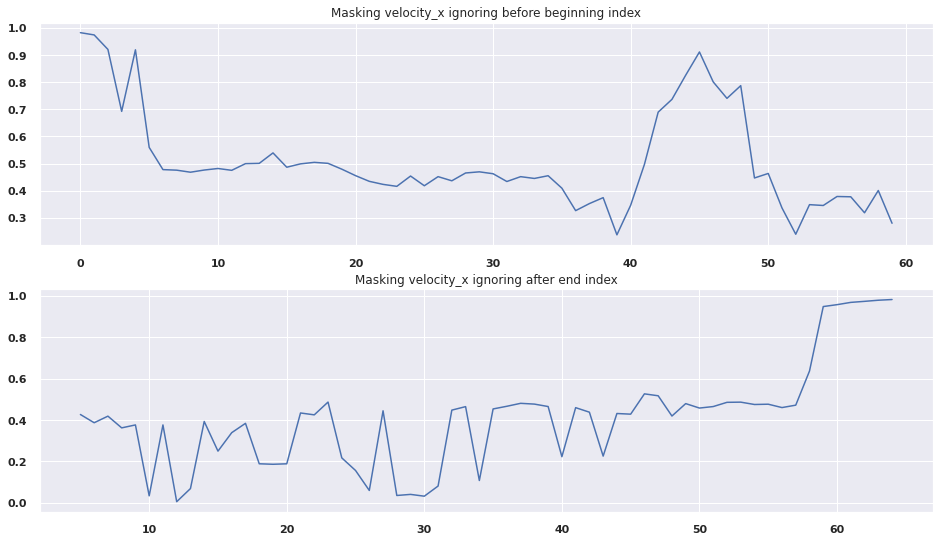

In [126]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 723, 0)

In [273]:
df = score_continuities_and_switching(nissan_csv_data, 723, [0, 4, 45], [59, 64])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
0,1.000000,15397,0,59,59,big,False
2,1.000000,15397,0,59,59,big,True
4,1.000000,15397,0,64,64,big,False
6,1.000000,15397,0,64,64,big,True
21,0.125000,15397,45,64,19,little,False
8,0.090909,15397,4,59,55,big,False
10,0.090909,15397,4,59,55,big,True
12,0.090909,15397,4,64,60,big,False
14,0.090909,15397,4,64,60,big,True
23,0.019231,15397,45,64,19,little,True


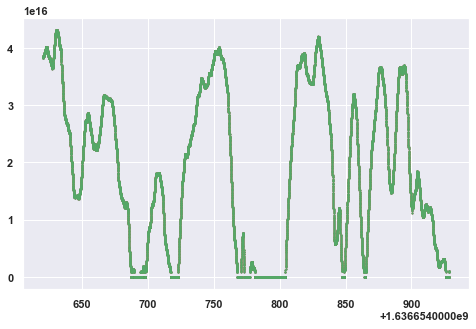

([1          1.636655e+09
  122        1.636655e+09
  265        1.636655e+09
  407        1.636655e+09
  516        1.636655e+09
                 ...     
  1954656    1.636655e+09
  1954802    1.636655e+09
  1954909    1.636655e+09
  1955030    1.636655e+09
  1955161    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  2          1.636655e+09
  121        1.636655e+09
  264        1.636655e+09
  408        1.636655e+09
  515        1.636655e+09
                 ...     
  1954657    1.636655e+09
  1954801    1.636655e+09
  1954908    1.636655e+09
  1955031    1.636655e+09
  1955160    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  5          1.636655e+09
  123        1.636655e+09
  274        1.636655e+09
  409        1.636655e+09
  519        1.636655e+09
                 ...     
  1954667    1.636655e+09
  1954807    1.636655e+09
  1954912    1.636655e+09
  1955036    1.636655e+09
  1955180    1.636655e+09
  Name: Time, Length: 15398, dtype: float64],
 [1   

In [282]:
plt.figure(figsize=(8, 5))
start_position = 0
end_position = 59
data_size = 64
message_id = 723
plot_message_id(nissan_csv_data,
                message_id, # message id
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=False,
               legend=False)

(15401,) 1010100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000111110100011010111011100110010 <class 'str'>
(15401,) 1110100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 0010100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 1100100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 0000100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 1101100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 0000100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 1101100001010010001001000010001000111110100011010111011100110010 <class 'numpy.str_'>
(15401,) 000000000101001000100100001000100011111010001101

(15401,) 1101111110010010100110111011100010110100000111010111011100110010 <class 'numpy.str_'>
(15401,) 0000000000000000000000000000000000000000000011010111011100110010 <class 'numpy.str_'>
(15401,) 1101111110010010100110111011100010110100000101010111011100110010 <class 'numpy.str_'>
(15401,) 0000000000000000000000000000000000000000000001010111011100110010 <class 'numpy.str_'>
(15401,) 1101111110010010100110111011100010110100000100010111011100110010 <class 'numpy.str_'>
(15401,) 0000000000000000000000000000000000000000000000010111011100110010 <class 'numpy.str_'>
(15401,) 1101111110010010100110111011100010110100000100110111011100110010 <class 'numpy.str_'>
(15401,) 0000000000000000000000000000000000000000000000010111011100110010 <class 'numpy.str_'>
(15401,) 1101111110010010100110111011100010110100000100110111011100110010 <class 'numpy.str_'>
(15401,) 0000000000000000000000000000000000000000000000000111011100110010 <class 'numpy.str_'>
(15401,) 11011111100100101001101110111000101101000

(15401,) 1010100001010010001001000010001000111101111110010010100110111011 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000110000000000000000000000000000 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000111011111100100101001101110111 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000100000000000000000000000000000 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000110111111001001010011011101110 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000000000000000000000000000000000 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001001101111110010010100110111011100 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000000000000000000000000000000000 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001011011111100100101001101110111000 <class 'numpy.str_'>
(15401,) 1010100001010010001001000010001000000000000000000000000000000000 <class 'numpy.str_'>
(15401,) 10101000010100100010010000100011101111110

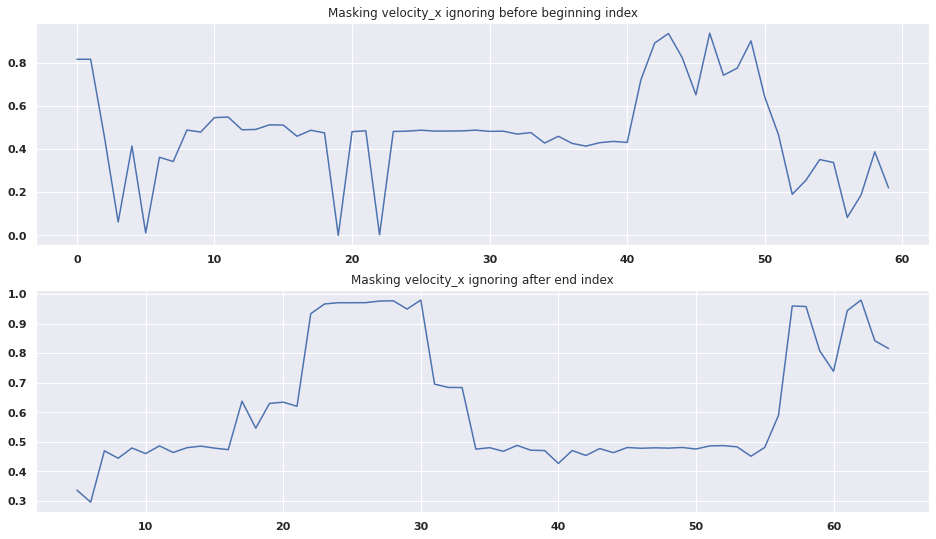

In [189]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 548, 0)

In [274]:
df = score_continuities_and_switching(nissan_csv_data, 548, [0, 1, 20, 21, 43, 49], [22, 23, 30, 33, 57, 58, 62])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
84,1.0,0,21,22,1,big,False
85,1.0,0,21,22,1,little,False
86,1.0,0,21,22,1,big,True
87,1.0,0,21,22,1,little,True
56,1.0,0,20,22,2,big,False
57,1.0,0,20,22,2,little,False
58,1.0,0,20,22,2,big,True
59,1.0,0,20,22,2,little,True
88,1.0,0,21,23,2,big,False
89,1.0,0,21,23,2,little,False


(15398,) 0010000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100101011000000001101011101110011 <class 'str'>
(15398,) 1110000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 1100000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 0000000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 0000000001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101100001100011001000000100011100101011000000001101011101110011 <class 'numpy.str_'>
(15398,) 000000000110001100100000010001110010101100000000

(15398,) 1101111110010010100110111011100010110100000100001101011101110011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100001101011101110011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100001101011101110011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100101101011101110011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101011101110011 <class 'numpy.str_'>
(15398,) 1101111110010010100110111011100010110100000100111101011101110011 <class 'numpy.str_'>
(15398,) 0000000000000000000000000000000000000000000000001101011101110011 <class 'numpy.str_'>
(15398,) 11011111100100101001101110111000101101000

(15398,) 0010000001100011001000000100011100101101111110010010100110111011 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100111011111100100101001101110111 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100100000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100110111111001001010011011101110 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011101101111110010010100110111011100 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011111011111100100101001101110111000 <class 'numpy.str_'>
(15398,) 0010000001100011001000000100011100000000000000000000000000000000 <class 'numpy.str_'>
(15398,) 00100000011000110010000001000111101111110

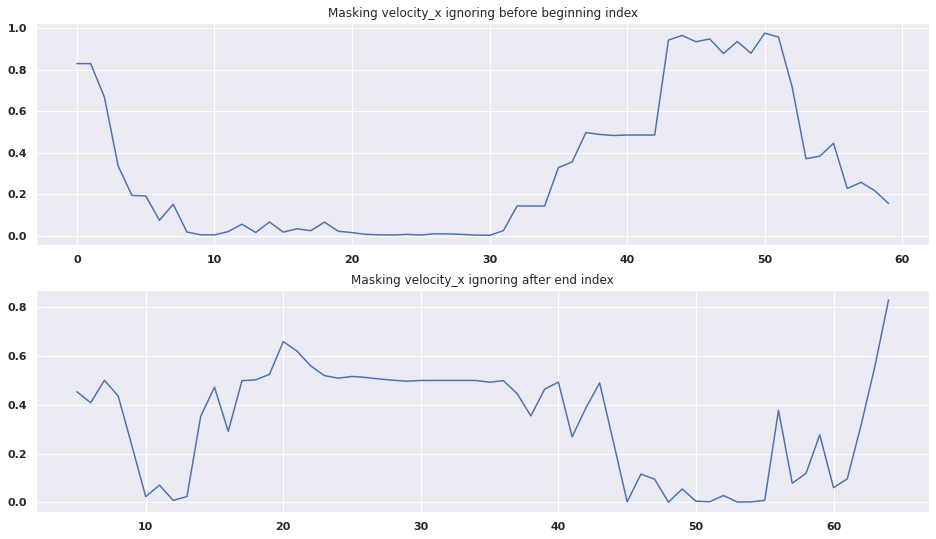

In [190]:
masking_from_beginning, masking_from_end = progressive_mask_on_signal_type(model, nissan_csv_data, 645, 0)

In [275]:
df = score_continuities_and_switching(nissan_csv_data, 645, [0, 1, 37, 43, 51], [20, 43, 56, 63])
df.head(10)

Auto detecting data size as 64 bits


,continuity_score,switch_score,position,end,length,byteorder,signed
52,1.0,15397,51,56,5,big,False
53,1.0,15397,51,56,5,little,False
54,1.0,15397,51,56,5,big,True
55,1.0,15397,51,56,5,little,True
56,1.0,15397,51,63,12,big,False
58,1.0,15397,51,63,12,big,True
44,1.0,15397,43,56,13,big,False
45,1.0,15397,43,56,13,little,False
46,1.0,15397,43,56,13,big,True
47,1.0,15397,43,56,13,little,True


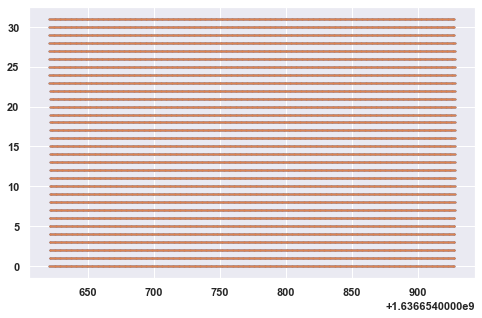

([64         1.636655e+09
  204        1.636655e+09
  348        1.636655e+09
  476        1.636655e+09
  574        1.636655e+09
                 ...     
  1954766    1.636655e+09
  1954884    1.636655e+09
  1954994    1.636655e+09
  1955114    1.636655e+09
  1955273    1.636655e+09
  Name: Time, Length: 15398, dtype: float64,
  65         1.636655e+09
  203        1.636655e+09
  347        1.636655e+09
  475        1.636655e+09
  575        1.636655e+09
                 ...     
  1954767    1.636655e+09
  1954883    1.636655e+09
  1954993    1.636655e+09
  1955113    1.636655e+09
  1955274    1.636655e+09
  Name: Time, Length: 15398, dtype: float64],
 [64         23
  204        24
  348        25
  476        26
  574        27
             ..
  1954766    24
  1954884    25
  1954994    26
  1955114    27
  1955273    28
  Name: Message, Length: 15398, dtype: int64,
  65         23
  203        24
  347        25
  475        26
  575        27
             ..
  1954767    24
  1

In [286]:
plt.figure(figsize=(8, 5))
start_position = 51
end_position = 56
data_size = 64
message_id = 645
plot_message_id(nissan_csv_data,
                message_id, # message id
                convert_to_big_endian_start(start_position - (64 - data_size)),
                end_position - start_position,
                byteorder='big',
                signed=False,
               legend=False)

### Filter out any signals that are counter signals. We are left with what is presented in the CANClassify paper.